In [1]:
import pandas as pd
import autosklearn.classification
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
)
from matplotlib import pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from autogluon.tabular import TabularDataset, TabularPredictor
import time
from IPython.display import display
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
seed = 42

In [45]:
train = pd.read_csv("./fashion_mnist/fashion-mnist_train.csv").sample(n=1000, random_state=seed)
test = pd.read_csv("./fashion_mnist/fashion-mnist_test.csv").sample(n=100, random_state=seed)
label = "label"
X_train, X_test, y_train, y_test = train.drop(columns=[label]), test.drop(columns=[label]), train[label], test[label]

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1000, 784) (1000,) (100, 784) (100,)


Ankle boot, Bag, Coat, Dress, Pullover, Sandal, Shirt, Sneaker, T-shirt/top, Trouser, 

<Figure size 432x288 with 0 Axes>

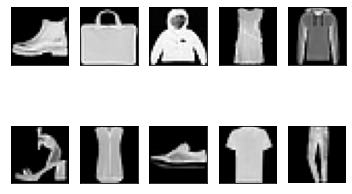

In [47]:
# visualize categories in the dataset
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_labels = y_train.apply(lambda x: target_names[x])
samples = X_train.loc[[x[0] for x in y_labels.reset_index().groupby("label").first().values]]
#setup image
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,5) 
for i, (idx, row) in enumerate(samples.iterrows()):
    pvals = np.array(row, dtype='float')
    pixels = pvals.reshape((28, 28))
    plt.subplot(2, 5, i+1)
    fig = plt.imshow(pixels, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    print(y_labels.loc[idx], end=", ")
plt.axis('off')
plt.show()

# Exhaustive search

1. Define pipeline options
2. Run all pipelines
3. Return the best pipeline

In [6]:
# define pipelines
def mi(X, y):
    return mutual_info_classif(X, y, random_state=seed)
preprocessing_options = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
]
feature_selection_options = [
    SelectKBest(score_func=f_classif, k=50),
    SelectKBest(score_func=mi, k=50),
]
model_options = [MLPClassifier(random_state=seed), AdaBoostClassifier(random_state=seed), DecisionTreeClassifier(random_state=seed), SVC(random_state=seed)]
stages = ["preprocessing", "feature selection", "models"]


def create_pipelines():
    pipelines = [
        Pipeline([_ for _ in zip(stages, pipeline)])
        for pipeline in product(
            preprocessing_options, feature_selection_options, model_options
        )
    ]
    return pipelines

In [7]:
# Execute pipelines
results = []
for pp in create_pipelines():
    print(pp)
    pp.fit(X_train, y_train)
    predictions = pp.predict(X_test)
    results.append(
        dict(
            [(key, str(val)) for key, val in pp.steps]
            + [("score", accuracy_score(y_test.tolist(), predictions))]
        )
    )
    print("============================================================")
exhaustive_search_result_df = pd.DataFrame(results)
display(exhaustive_search_result_df)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feature selection', SelectKBest(k=50)),
                ('models', MLPClassifier(random_state=42))])
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feature selection', SelectKBest(k=50)),
                ('models', AdaBoostClassifier(random_state=42))])
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feature selection', SelectKBest(k=50)),
                ('models', DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feature selection', SelectKBest(k=50)),
                ('models', SVC(random_state=42))])
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feature selection',
                 SelectKBest(k=50, score_func=<function mi at 0x7f0894a7a8b0>)),
                ('models', MLPClassifier(random_state=42))])
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('feat

,preprocessing,feature selection,models,score
0,StandardScaler(),SelectKBest(k=50),MLPClassifier(random_state=42),0.63
1,StandardScaler(),SelectKBest(k=50),AdaBoostClassifier(random_state=42),0.25
2,StandardScaler(),SelectKBest(k=50),DecisionTreeClassifier(random_state=42),0.63
3,StandardScaler(),SelectKBest(k=50),SVC(random_state=42),0.66
4,StandardScaler(),"SelectKBest(k=50, score_func=<function mi at 0...",MLPClassifier(random_state=42),0.64
5,StandardScaler(),"SelectKBest(k=50, score_func=<function mi at 0...",AdaBoostClassifier(random_state=42),0.23
6,StandardScaler(),"SelectKBest(k=50, score_func=<function mi at 0...",DecisionTreeClassifier(random_state=42),0.58
7,StandardScaler(),"SelectKBest(k=50, score_func=<function mi at 0...",SVC(random_state=42),0.66
8,RobustScaler(),SelectKBest(k=50),MLPClassifier(random_state=42),0.62
9,RobustScaler(),SelectKBest(k=50),AdaBoostClassifier(random_state=42),0.25


In [6]:
# pipeline with highest r2_score
print(exhaustive_search_result_df.loc[exhaustive_search_result_df["score"].idxmax()])

preprocessing                                           MinMaxScaler()
feature selection    SelectKBest(k=50, score_func=<function mi at 0...
models                                            SVC(random_state=42)
score                                                             0.68
Name: 23, dtype: object


## Execute pipelines in parallel using joblib

1. Executing pipelines is an embarassingly parallel job
2. Pipelines can be executed independently on all available cores
3. We use Python's joblib package for parallel execution

## Further optimizations

Execution time can be further improved by 
1. Using multiple machines
2. Pipelines share common subtasks. Results of these subtasks can be shared across cores and machines

In [7]:
from joblib import Parallel, delayed
from tqdm import tqdm


def workerfunc(args):
    X_train, y_train, X_test, y_test, pp = args
    pp.fit(X_train, y_train)
    predictions = pp.predict(X_test)
    return accuracy_score(y_test, predictions)


with Parallel(n_jobs=-1) as parallel:
    tasks = [[X_train, y_train, X_test, y_test, pp] for pp in create_pipelines()]
    results_parallel = parallel(delayed(workerfunc)(args) for args in tqdm(tasks))
    exhaustive_search_parallel_result_df = pd.DataFrame(
        zip([x[-1] for x in tasks], results_parallel), columns=["pipeline", "score"]
    )
    display(exhaustive_search_parallel_result_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 61539.54it/s]


,pipeline,score
0,"(StandardScaler(), SelectKBest(k=50), MLPClass...",0.63
1,"(StandardScaler(), SelectKBest(k=50), (Decisio...",0.25
2,"(StandardScaler(), SelectKBest(k=50), Decision...",0.63
3,"(StandardScaler(), SelectKBest(k=50), SVC(rand...",0.66
4,"(StandardScaler(), SelectKBest(k=50, score_fun...",0.64
5,"(StandardScaler(), SelectKBest(k=50, score_fun...",0.23
6,"(StandardScaler(), SelectKBest(k=50, score_fun...",0.58
7,"(StandardScaler(), SelectKBest(k=50, score_fun...",0.66
8,"(RobustScaler(), SelectKBest(k=50), MLPClassif...",0.62
9,"(RobustScaler(), SelectKBest(k=50), (DecisionT...",0.25


In [8]:
# pipeline with best r2_score using parallel exhaustive search
print(
    exhaustive_search_parallel_result_df.loc[
        exhaustive_search_parallel_result_df["score"].idxmax()
    ]
)

pipeline    (MinMaxScaler(), SelectKBest(k=50, score_func=...
score                                                    0.68
Name: 23, dtype: object


# Genetic programming
1. TPOT package (https://epistasislab.github.io/tpot/)
2. Initialized with number of generations, population size, maximum time

In [9]:
# tpo   t genetic algorithms
from tpot import TPOTClassifier

tpot = TPOTClassifier(
    generations=15,
    population_size=10,
    verbosity=2,
    random_state=42,
    max_time_mins=1,
    n_jobs=-1,
)
tpot.fit(X_train, y_train)
predictions = tpot.predict(X_test)
display(accuracy_score(y_test.tolist(), predictions))

Optimization Progress:   0%|          | 0/10 [00:00<?, ?pipeline/s]


1.36 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(MinMaxScaler(input_matrix), bootstrap=True, criterion=gini, max_features=0.2, min_samples_leaf=8, min_samples_split=4, n_estimators=100)


0.78

# Bayesian optimization

1. Uses same interface as scikit-learn https://automl.github.io/auto-sklearn/master/#

In [87]:
# bayesian optimization
import autosklearn.classification
automl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=30, memory_limit=None, n_jobs=-1)
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)

Process ForkServerProcess-150:
Traceback (most recent call last):
  File "/home/pranay/anaconda3/envs/pdsworkshop/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/pranay/anaconda3/envs/pdsworkshop/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pranay/anaconda3/envs/pdsworkshop/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 320, in start_log_server
    receiver.serve_until_stopped()
  File "/home/pranay/anaconda3/envs/pdsworkshop/lib/python3.8/site-packages/autosklearn/util/logging_.py", line 350, in serve_until_stopped
    rd, wr, ex = select.select([self.socket.fileno()],
KeyboardInterrupt


[WARNING] [2021-11-08 22:53:24,426:Client-AutoML(1):9576404f-4110-11ec-84a7-91aec9db9ac5] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (29.473475)
[WARNING] [2021-11-08 22:53:24,426:Client-AutoML(1):9576404f-4110-11ec-84a7-91aec9db9ac5] Capping the per_run_time_limit to 14.0 to have time for a least 2 models in each process.


In [88]:
# best r2_score using AutoSklearn
print("accuracy score:", accuracy_score(y_test.tolist(), predictions))
print(automl.show_models())

accuracy score: 0.82
[(0.260000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'random_forest', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5274952518831024, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 2, 'classifier:random_forest:min_samples_split': 3, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:stra

# AutoGluon (https://auto.gluon.ai/stable/index.html#)

In [92]:
save_path = 'autogluon-fashion-mnist'  # specifies folder to store trained models
label = "label"
time_limit = 60  # for quick demonstration only, you should set this to longest time you are willing to wait (in seconds)
metric = 'accuracy'  # specify your evaluation metric here
predictor = TabularPredictor(label="label", path=save_path).fit(train,  time_limit=time_limit, presets='best_quality')

[WARNING] [2021-11-08 22:57:01,548:autogluon.core.utils.utils] Warning: path already exists! This predictor may overwrite an existing predictor! path="autogluon-fashion-mnist"
[WARNING] [2021-11-08 22:57:41,840:autogluon.tabular.models.rf.rf_model] 	Warning: Model is expected to require 1.7s to train, which exceeds the maximum time limit of 0.2s, skipping model...


In [93]:
y_test = test[label]  # values to predict
test_data_nolab = test.drop(columns=[label])  # delete label column to prove we're not cheating
test_data_nolab.head()
y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Predictions:  
 9953    1
3850    4
4962    4
3886    7
5437    5
       ..
4699    7
3057    3
1185    7
3207    6
9462    1
Name: label, Length: 100, dtype: int64


In [94]:
predictor.leaderboard(test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.85,0.827,0.199273,0.065062,33.922584,0.199273,0.065062,33.922584,1,True,3
1,WeightedEnsemble_L2,0.85,0.827,0.200418,0.066172,34.027564,0.001146,0.001110,0.104979,2,True,4
2,LightGBMXT_BAG_L2,0.82,0.805,1.053616,2.556194,51.697826,0.071473,0.058544,17.661604,2,True,5
3,WeightedEnsemble_L3,0.82,0.805,1.054507,2.558204,51.699962,0.000891,0.002010,0.002136,3,True,6
4,KNeighborsDist_BAG_L1,0.77,0.771,0.317087,0.777494,0.063977,0.317087,0.777494,0.063977,1,True,2
5,KNeighborsUnif_BAG_L1,0.77,0.766,0.465784,1.655094,0.049661,0.465784,1.655094,0.049661,1,True,1
